In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras.layers import  Dense, Input, InputLayer, Flatten
from tensorflow.keras.models import Sequential, Model
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

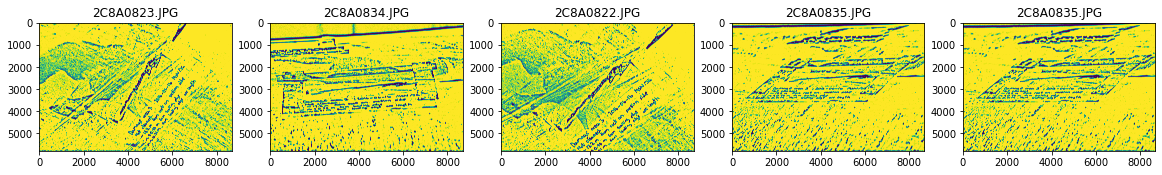

In [6]:
import random
plt.figure(figsize=(20,20))
img_folder=r'/content/drive/MyDrive/Adaptive_Turbine_Set/Damage_Area'
for i in range(5):
    file = random.choice(os.listdir(img_folder))
    image_path= os.path.join(img_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

In [7]:
damage_dir =r'/content/drive/MyDrive/Adaptive_Turbine_Set/Damage_Area'
erosion_dir =r'/content/drive/MyDrive/Adaptive_Turbine_Set/Erosion_Area'
edge_dir = r'/content/drive/MyDrive/Adaptive_Turbine_Set/Edge_Area'
reference_dir =r'/content/drive/MyDrive/Adaptive_Turbine_Set/Reference_Area'


In [8]:
print('total damaged images:', len(os.listdir(damage_dir)))
print('total erosion images:', len(os.listdir(erosion_dir)))
print('total edge area images:', len(os.listdir(edge_dir)))
print('total reference area images:', len(os.listdir(reference_dir)))


total damaged images: 8
total erosion images: 27
total edge area images: 30
total reference area images: 16


In [9]:
train_damage_names = os.listdir(damage_dir)
print(train_damage_names[:5])

train_erosion_names = os.listdir(erosion_dir)
print(train_erosion_names[:5])

train_edge_names = os.listdir(edge_dir)
print(train_edge_names[:5])

train_reference_names = os.listdir(reference_dir)
print(train_reference_names[:5])

['2C8A0822.JPG', '2C8A0823.JPG', '2C8A0824.JPG', '2C8A0834.JPG', '2C8A0835.JPG']
['2C8A0751.JPG', '2C8A0753.JPG', '2C8A0752.JPG', '2C8A0754.JPG', '2C8A0756.JPG']
['2C8A0861.JPG', '2C8A0863.JPG', '2C8A0862.JPG', '2C8A0864.JPG', '2C8A0865.JPG']
['2C8A0838.JPG', '2C8A0837.JPG', '2C8A0839.JPG', '2C8A0840.JPG', '2C8A0842.JPG']


Showing some damage pictures



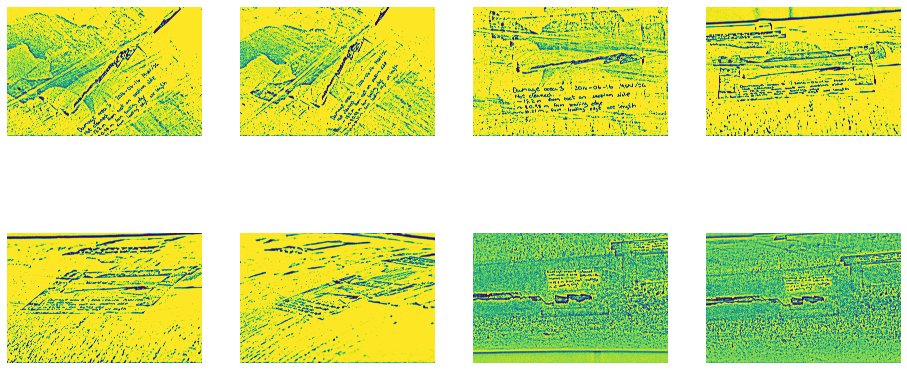

Showing some erosion pictures



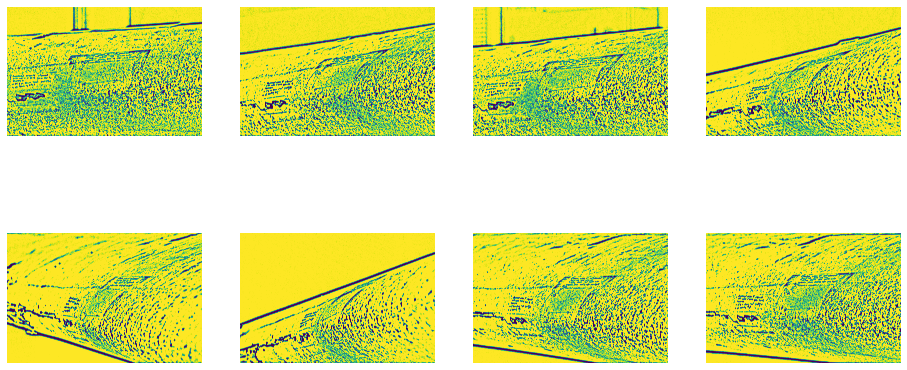

In [10]:
nrows = 4
ncols = 4
pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_damage_pix = [os.path.join(damage_dir, fname) 
                for fname in train_damage_names[pic_index-8:pic_index]]
next_erosion_pix = [os.path.join(erosion_dir, fname) 
                for fname in train_erosion_names[pic_index-8:pic_index]]

print ("Showing some damage pictures")
print()
for i, img_path in enumerate(next_damage_pix):
 
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') 

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

print ("Showing some erosion pictures")
print()
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)
for i, img_path in enumerate(next_erosion_pix):
  
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') 

  img = mpimg.imread(img_path)
  plt.imshow(img)
plt.show()

In [11]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255)
batch_size = 646

dir = r'/content/drive/MyDrive/Adaptive_Turbine_Set'
train_generator = train_datagen.flow_from_directory(dir , 
        target_size=(320, 320),  
        batch_size=batch_size,
        classes = ['Damage_Area','Edge_Area','Erosion_Area','Reference_Area'],
        class_mode='categorical')

val_datagen = tf.keras.preprocessing.image_dataset_from_directory(
  dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  batch_size=batch_size)

Found 81 images belonging to 4 classes.
Found 81 files belonging to 4 classes.
Using 16 files for validation.


In [12]:
img_w, img_h = 220, 220 

4 classes with 81 images in total


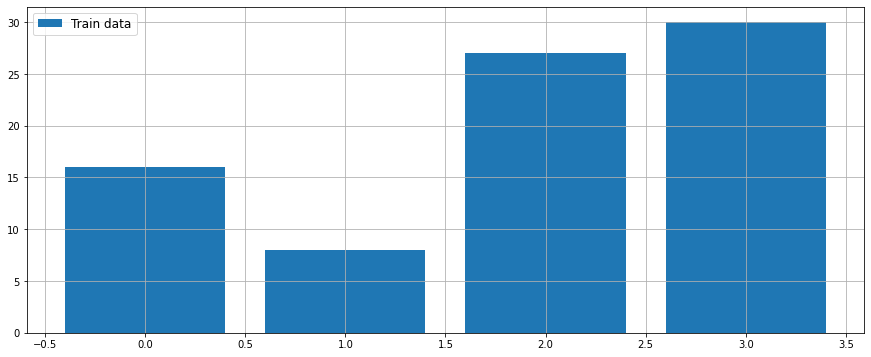

In [13]:
CLASSES, image = [], [] 
for root, dirs, files in os.walk(r'/content/drive/MyDrive/Adaptive_Turbine_Set'):
    f = os.path.basename(root)      
        
    if len(files) > 0:
        image.append(len(files))
        if f not in CLASSES:
            CLASSES.append(f) 
    
image_count = len(CLASSES) 
print('{} classes with {} images in total'.format(len(CLASSES), sum(image)))

f, ax = plt.subplots(figsize=(15,6))
if(image[0])<10:
    plt.bar(range(image_count ), image[image_count :], label = 'Train data')
    plt.bar(range(image_count ), image[0:image_count ], label = 'Test data')
else:
    plt.bar(range(image_count ), image[0:image_count ], label = 'Train data')
   
ax.grid()
ax.legend(fontsize = 12);

In [14]:
def read_imgs_lbls(dir):
    Images, Labels = [], []
    for root, dirs, files in os.walk(dir):
        f = os.path.basename(root)        
        for file in files:
            Labels.append(f)
            try:
                image1 = cv2.imread(root+'/'+file)             
                image1 = cv2.resize(image1,(int(img_w*1.5), int(img_h*1.5)))       
                image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
                Images.append(image1)
            except Exception as e:
                print(e)
    Images = np.array(Images)
    return (Images, Labels)

In [15]:
def get_class_index(Labels):
    for i, n in enumerate(Labels):
        for j, k in enumerate(CLASSES):  
            if n == k:
                Labels[i] = j
    Labels = np.array(Labels)
    return Labels

In [16]:
_dir = r'/content/drive/MyDrive/Adaptive_Turbine_Set'
Train_Imgs, Train_Lbls = read_imgs_lbls(_dir)
Train_Lbls = get_class_index(Train_Lbls)
print('Shape of train images: {}'.format(Train_Imgs.shape))
print('Shape of train labels: {}'.format(Train_Lbls.shape))

Shape of train images: (81, 330, 330, 3)
Shape of train labels: (81,)


In [17]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(Train_Imgs, Train_Lbls, shuffle = True, test_size = 0.2, random_state = 42)
print('Shape of X_train: {}, y_train: {} '.format(X_train.shape, y_train.shape))
print('Shape of X_val: {}, y_val: {} '.format(X_val.shape, y_val.shape))

Shape of X_train: (64, 330, 330, 3), y_train: (64,) 
Shape of X_val: (17, 330, 330, 3), y_val: (17,) 


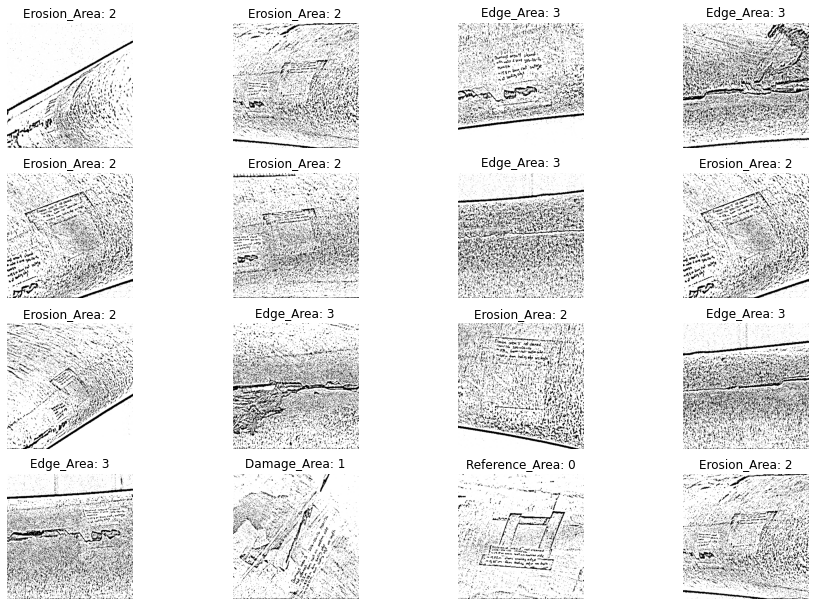

In [18]:
from random import randint
dim = 4

f,ax = plt.subplots(dim,dim) 
f.subplots_adjust(0,0,2,2)
for i in range(0,dim):
    for j in range(0,dim):
        rnd_number = randint(0,len(Train_Imgs))
        cl = Train_Lbls[rnd_number]
        ax[i,j].imshow(Train_Imgs[rnd_number])
        ax[i,j].set_title(CLASSES[cl]+': ' + str(cl))
        ax[i,j].axis('off')

In [19]:
def edge_and_cut(img):
    try:
        edges = cv2.Canny(img, img_w, img_h)            
        
        if(np.count_nonzero(edges)>edges.size/10000):           
            pts = np.argwhere(edges>0)
            y1,x1 = pts.min(axis=0)
            y2,x2 = pts.max(axis=0)
            
            new_img = img[y1:y2, x1:x2]          
            new_img = cv2.resize(new_img,(img_w, img_h))  
        else:
            new_img = cv2.resize(img,(img_w, img_h))
    
    except Exception as e:
        print(e)
        new_img = cv2.resize(img,(img_w, img_h))
    
    return new_img

In [20]:
def show_cropped(img):
    emb_img = img.copy()
    edges = cv2.Canny(img, img_w, img_h)
    
    if(np.count_nonzero(edges)>edges.size/10000):
        pts = np.argwhere(edges>0)
        y1,x1 = pts.min(axis=0)
        y2,x2 = pts.max(axis=0)

        new_img = img[y1:y2, x1:x2]  

        edge_size = 1           

        emb_img[y1-edge_size:y1+edge_size, x1:x2] = [255, 0, 0]
        emb_img[y2-edge_size:y2+edge_size, x1:x2] = [255, 0, 0]
        emb_img[y1:y2, x1-edge_size:x1+edge_size] = [255, 0, 0]
        emb_img[y1:y2, x2-edge_size:x2+edge_size] = [255, 0, 0]

        new_img = cv2.resize(new_img,(img_w, img_h))    
        
    else:
        new_img = cv2.resize(img,(img_w, img_h))
    
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 10))
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Original Image', fontsize=14)
    ax[1].imshow(edges, cmap='gray')
    ax[1].set_title('Canny Edges', fontsize=14)
    ax[2].imshow(emb_img, cmap='gray')
    ax[2].set_title('Bounding Box', fontsize=14)       
    ax[3].imshow(new_img, cmap='gray')
    ax[3].set_title('Cropped', fontsize=14) 

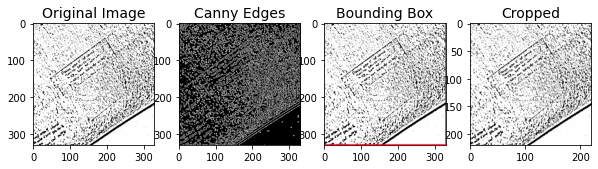

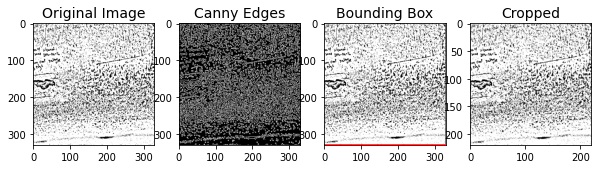

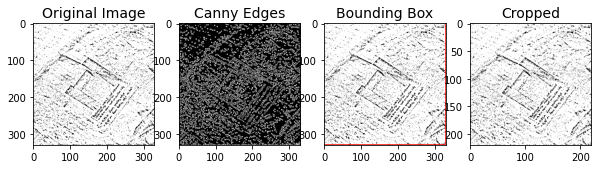

In [21]:
for x in range(0,3):
    show_cropped(Train_Imgs[randint(0,len(Train_Imgs))])

In [22]:
def crop_images(Imgs):
    CroppedImages = np.ndarray(shape=(len(Imgs), img_w, img_h, 3), dtype=np.int)

    ind = 0
    for im in Imgs: 
        x = edge_and_cut(im)
        CroppedImages[ind] = x
        ind += 1

    return CroppedImages

In [23]:
Train_Imgs = crop_images(Train_Imgs)
print('Final shape of images in train set: {} '.format(Train_Imgs.shape))

Final shape of images in train set: (81, 220, 220, 3) 


In [24]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(Train_Imgs, Train_Lbls, shuffle = True, test_size = 0.2, random_state = 42)
print('Shape of X_train: {}, y_train: {} '.format(X_train.shape, y_train.shape))
print('Shape of X_val: {}, y_val: {} '.format(X_val.shape, y_val.shape))

Shape of X_train: (64, 220, 220, 3), y_train: (64,) 
Shape of X_val: (17, 220, 220, 3), y_val: (17,) 


In [25]:
filters = 32      
kernel_size = 3   
max_pool = 3 

In [26]:
EPOCHS = 20                                
batch_size = 32                             
iter_per_epoch = len(X_train) // batch_size  
val_per_epoch = len(X_val) // batch_size     

In [27]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers

In [28]:
model = Sequential()
model.add(Conv2D(batch_size, (kernel_size, kernel_size), activation='relu', padding='same', input_shape=(img_w, img_h, 3))) # 32
model.add(MaxPooling2D((max_pool, max_pool))) #reduce the spatial size of incoming features
model.add(Conv2D(2*batch_size, (kernel_size, kernel_size), activation='relu', padding='same')) # 64
model.add(MaxPooling2D((max_pool, max_pool))) 
model.add(Conv2D(4*batch_size, (kernel_size, kernel_size), activation='relu', padding='same')) # 128
model.add(MaxPooling2D((max_pool, max_pool))) 
model.add(Conv2D(4*batch_size, (kernel_size, kernel_size), activation='relu', padding='same')) # 128
model.add(AveragePooling2D(pool_size= (2, 2), strides= (2, 2))) 
model.add(Conv2D(4*batch_size, (kernel_size, kernel_size), activation='relu', padding='same')) # 128
model.add(MaxPooling2D((max_pool, max_pool))) 

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(16*batch_size, activation='relu'))                                             # 512
model.add(Dense(87, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 73, 73, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         1

In [29]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [30]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(              
        rotation_range=25,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        horizontal_flip=True
        )

val_datagen = ImageDataGenerator()

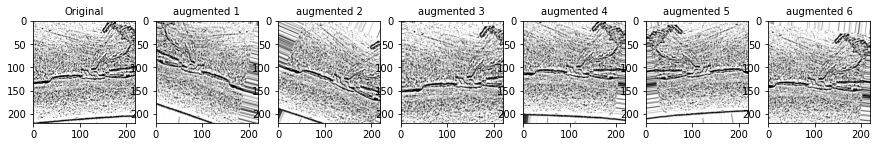

In [31]:
from random import randint
n = randint(0,len(X_train))
samples = np.expand_dims(X_train[n], 0)
it = train_datagen.flow(samples, batch_size=batch_size)
cols = 7
fig, ax = plt.subplots(nrows=1, ncols=cols, figsize=(15, 10))
ax[0].imshow(X_train[n], cmap='gray')
ax[0].set_title('Original', fontsize=10)

for i in range(1,cols):
    batch = it.next()    
    image = batch[0].astype('uint32') 
    ax[i].set_title('augmented {}'.format(i), fontsize=10)
    ax[i].imshow(image, cmap='gray')

In [32]:
train_gen = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_gen = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [43]:
history = model.fit_generator(
       train_gen,
       steps_per_epoch= iter_per_epoch,
       epochs=EPOCHS, 
       validation_data = val_gen,
       validation_steps = val_per_epoch,
       verbose=1 
       )

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
2/2 [==============================] - 4s 2s/step - loss: 0.3766 - accuracy: 0.8750
Epoch 2/20
2/2 [==============================] - 4s 2s/step - loss: 0.4800 - accuracy: 0.7969
Epoch 3/20
2/2 [==============================] - 4s 2s/step - loss: 0.4742 - accuracy: 0.8281
Epoch 4/20
2/2 [==============================] - 4s 2s/step - loss: 0.4229 - accuracy: 0.8906
Epoch 5/20
2/2 [==============================] - 4s 2s/step - loss: 0.4676 - accuracy: 0.8438
Epoch 6/20
2/2 [==============================] - 4s 2s/step - loss: 0.6234 - accuracy: 0.7031
Epoch 7/20
2/2 [==============================] - 4s 2s/step - loss: 0.6487 - accuracy: 0.7344
Epoch 8/20
2/2 [==============================] - 4s 2s/step - loss: 0.3705 - accuracy: 0.9219
Epoch 9/20
2/2 [==============================] - 4s 2s/step - loss: 0.6848 - accuracy: 0.7656
Epoch 10/20
2/2 [==============================] - 4s 2s/step - loss: 0.5150 - accuracy: 0.8125
Epoch 11/20
2/2 [==============================] 

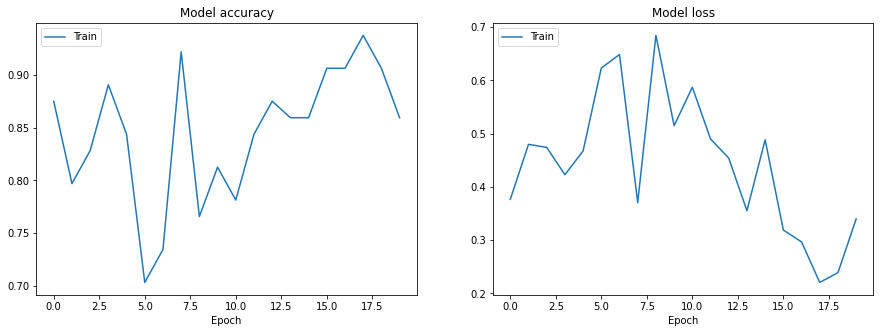

In [45]:
#Type 2 of plotting

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axs[0].plot(history.history['accuracy'])
axs[0].set_title('Model accuracy')
axs[0].legend(['Train', 'Val'], loc='upper left')

axs[1].plot(history.history['loss'])
axs[1].set_title('Model loss')
axs[1].legend(['Train', 'Val'], loc='upper left')

for ax in axs.flat:
    ax.set(xlabel='Epoch')

In [46]:
score = model.evaluate_generator(val_gen, steps= len(val_gen))

for idx, metric in enumerate(model.metrics_names):
    print('{}:{}'.format(metric, score[idx]))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


loss:8.98740291595459
accuracy:0.23529411852359772


Text(0.5, 21.5, 'Predicted label')

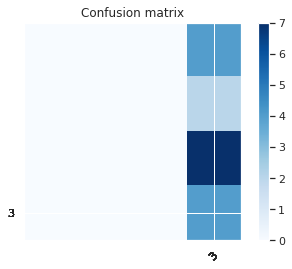

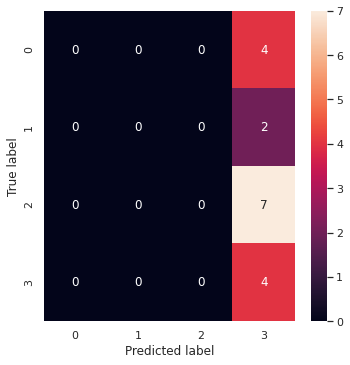

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set_theme()

y_pre_test=model.predict(X_val)
y_pre_test=np.argmax(y_pre_test,axis=1)
cm=confusion_matrix(y_val,y_pre_test)

title='Confusion matrix' 
cmap=plt.cm.Blues
plt.imshow(cm, interpolation='nearest', cmap=cmap)

plt.title(title)
plt.colorbar()
y_pre_test=model.predict(X_val)
y_pre_test=np.argmax(y_pre_test,axis=1)

plt.xticks(y_pre_test, rotation=45)
plt.yticks(y_pre_test)

plt.figure(figsize = (5,5))

cm=confusion_matrix(y_val,y_pre_test)
sns.heatmap(cm, annot=True)
plt.tight_layout()

plt.ylabel('True label')

plt.xlabel('Predicted label')



In [50]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_val, y_pre_test)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[0 0 0 4]
 [0 0 0 2]
 [0 0 0 7]
 [0 0 0 4]]


In [51]:
#importing confusion matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_val, y_pre_test)
print('Confusion Matrix\n')
print(confusion)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_val, y_pre_test)))

print('Micro Precision: {:.2f}'.format(precision_score(y_val, y_pre_test, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_val, y_pre_test, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_val, y_pre_test, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_val, y_pre_test, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_val, y_pre_test, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_val, y_pre_test, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_val, y_pre_test, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_val, y_pre_test, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_val, y_pre_test, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
target_names=['Class 1', 'Class 2', 'Class 3','Class 4']
print(classification_report(y_val, y_pre_test))

Confusion Matrix

[[0 0 0 4]
 [0 0 0 2]
 [0 0 0 7]
 [0 0 0 4]]

Accuracy: 0.24

Micro Precision: 0.24
Micro Recall: 0.24
Micro F1-score: 0.24

Macro Precision: 0.06
Macro Recall: 0.25
Macro F1-score: 0.10

Weighted Precision: 0.06
Weighted Recall: 0.24
Weighted F1-score: 0.09

Classification Report

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         7
           3       0.24      1.00      0.38         4

    accuracy                           0.24        17
   macro avg       0.06      0.25      0.10        17
weighted avg       0.06      0.24      0.09        17



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


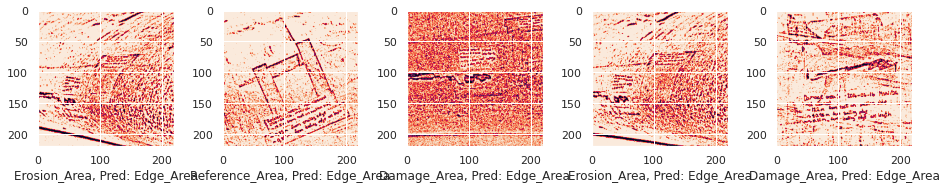

In [52]:
x=(y_pre_test-y_val!=0).tolist()
x=[i for i,l in enumerate(x) if l!=False]

fig,ax=plt.subplots(1,5,sharey=False,figsize=(13,13))
fig.tight_layout()

for i in range(5):
    ax[i].imshow(X_val[x[i]][:,:,1])
    ax[i].set_xlabel('{}, Pred: {}'.format(CLASSES[y_val[x[i]]],CLASSES[y_pre_test[x[i]]]))